In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import torch
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from tqdm import trange, tqdm
from time import sleep
from algorithms import fit
from utils import latexify

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
latexify()

/Users/avajiang/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
# if torch.cuda.is_available():  
#     print('cuda available')
#     dev = "cuda:0" 
# else:  
#     dev = "cpu"  
# device = torch.device(dev)

# helper functions

In [3]:
def f_plot(Sx0,X,i):
    S,x0 = Sx0[:,0],Sx0[:,1]
    p = torch.square(S)
    quad = torch.square(torch.linalg.norm(S*X[:,i]))
    lin = torch.dot(X[:,i]*p,torch.sum(X[:,np.arange(m)!=i],axis=1) + x0)
    return quad + lin

In [37]:
def plot_results(val_losses, train_losses, param_updates, obj_vals, gamma_true, Sx0, X_untrained, X_trained, X_true, dist):
    epochs = len(val_losses)
    
    # loss by epoch
    plt.figure(figsize=(6,4))
    plt.plot(val_losses, 'k', label='val')
    plt.plot([np.mean(tl) for tl in train_losses], 'k--', label='train')
    plt.xlabel('epoch')
    plt.ylabel('loss')
#     plt.title('Validation and training loss by epoch')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figures/pev2/loss_%s.pdf'%dist)
    
    # norm(gamma) updates by epoch
    plt.figure(figsize=(6,4))
    plt.plot(np.linalg.norm(param_updates.detach().numpy(),axis=1), 'k', label='$||\gamma||$')
    plt.hlines(np.linalg.norm(gamma_true), 0, epochs, colors='k', linestyles='dashed', label='$||\gamma^\mathrm{true}||$')
    plt.xlabel('epoch')
    plt.ylabel('$||\gamma||$')
#     plt.title('$||\gamma||$ updates by epoch')
    plt.legend()
    plt.savefig('figures/pev2/gamma_%s.pdf'%dist)
    
    # gamma updates by epoch
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
    plt.gcf().clear()
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    for i in range(m):
        ax.plot(param_updates[:,i].detach().numpy(), color=colors[i], label='$\gamma_%d$'%(i+1))
        ax.hlines(gamma_true[i], 0, epochs, colors=colors[i], linestyles='dashed', label='$\gamma_%d^\mathrm{true}$'%(i+1))
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('$\gamma$')
#     ax.set_title('$\gamma$ updates by epoch')
    fig.savefig('figures/pev2/gamma_indiv_%s.pdf'%dist, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    # objective value by epoch
    plt.figure(figsize=(6,4))
    plt.plot(obj_vals, 'k', label='train')
    plt.hlines(f_plot(Sx0[0,:,:],X_true[0,:,:],0), 0, epochs-1, colors='k', linestyles='dashed', label='true')
#     plt.title('Objective value by epoch')
    plt.xlabel('epoch')
    plt.ylabel('objective value')
    plt.legend()
    plt.savefig('figures/pev2/objval_%s.pdf'%dist)
    
    # untrained vs. trained vs. true
    plt.figure(figsize=(6,4))
    plt.plot(X_untrained[:,0].detach().numpy(), linestyle='dotted', label='untrained')
    plt.plot(X_trained[:,0].detach().numpy(), label='trained')
    plt.plot(X_true[0,:,0], '--', label='true')
#     plt.title('$x_1$ over time')
    plt.xlabel('$t$')
    plt.ylabel('$x_1$')
    plt.legend()
    plt.savefig('figures/pev2/x_%s.pdf'%dist)

# setup

In [6]:
h = 100   # time horizon
m = 5     # number of vehicles

In [7]:
def constr(x,i,x0,gamma):
    x_i = x[:,i]
    constraints = None
    if i==0:
        constraints = [x_i == x0]
    else:
        constraints = [cp.sum(x_i) == gamma[i-1],
                       x_i >= 0,
                       x_i <= 1]
    return constraints

# method 1: centralized

In [8]:
x = cp.Variable((h,m+1))
s = cp.Variable(h)
Sx0 = cp.Parameter((h,2))
gamma = cp.Parameter(m)

objective = cp.sum_squares(cp.multiply(Sx0[:,0],s))
constraints = [c for i in range(m+1) for c in constr(x,i,Sx0[:,1],gamma)] + [s == cp.sum(x,axis=1)]
prob = cp.Problem(cp.Minimize(objective), constraints)

layer = CvxpyLayer(prob, [Sx0,gamma], [x,s])

## forward pass

In [9]:
# get data
def get_data_nd(N,gamma):
    p,x0 = torch.rand(N,h),torch.rand(N,h)
    S = torch.sqrt(p)
    Sx0 = torch.dstack((S,x0))
    gamma = gamma.repeat(N,1)
    x,_ = layer(Sx0,gamma,solver_args={"solve_method":'ECOS'})
    return Sx0,x

gamma_true = torch.rand(m)*10
print(gamma_true)

Sx0,X_nd = get_data_nd(100, gamma_true)
Sx0val,Xval_nd = get_data_nd(50, gamma_true)

tensor([4.9626, 7.6822, 0.8848, 1.3203, 3.0742])


## backward pass

In [10]:
l1_loss = torch.nn.L1Loss()
torch.manual_seed(1)
gamma = torch.rand(m)*10
print(gamma)
gamma.requires_grad_(True)

def loss_nd(Sx0,x,gamma):
    N = Sx0.shape[0]
    gamma = gamma.repeat(N,1)
    return l1_loss(layer(Sx0,gamma,solver_args={"solve_method":'ECOS'})[0],x)

tensor([7.5763, 2.7931, 4.0307, 7.3468, 0.2928])


In [11]:
epochs = 30
val_losses_nd, train_losses_nd, param_updates_nd = fit(lambda Sx0,X: loss_nd(Sx0,X,gamma), [gamma], Sx0, X_nd, Sx0val, Xval_nd,
                                                       opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                                                       batch_size=20, epochs=epochs, verbose=True)

001 | 0.03262
batch 001 / 005 | 0.03262
batch 002 / 005 | 0.03217
batch 003 / 005 | 0.03177
batch 004 / 005 | 0.03137
batch 005 / 005 | 0.03094
002 | 0.02846
batch 001 / 005 | 0.02848
batch 002 / 005 | 0.02804
batch 003 / 005 | 0.02761
batch 004 / 005 | 0.02720
batch 005 / 005 | 0.02679
003 | 0.02431
batch 001 / 005 | 0.02432
batch 002 / 005 | 0.02391
batch 003 / 005 | 0.02349
batch 004 / 005 | 0.02311
batch 005 / 005 | 0.02272
004 | 0.02032
batch 001 / 005 | 0.02031
batch 002 / 005 | 0.01998
batch 003 / 005 | 0.01963
batch 004 / 005 | 0.01924
batch 005 / 005 | 0.01888
005 | 0.01656
batch 001 / 005 | 0.01676
batch 002 / 005 | 0.01630
batch 003 / 005 | 0.01593
batch 004 / 005 | 0.01566
batch 005 / 005 | 0.01531
006 | 0.01313
batch 001 / 005 | 0.01317
batch 002 / 005 | 0.01290
batch 003 / 005 | 0.01265
batch 004 / 005 | 0.01235
batch 005 / 005 | 0.01205
007 | 0.01015
batch 001 / 005 | 0.01029
batch 002 / 005 | 0.01021
batch 003 / 005 | 0.00991
batch 004 / 005 | 0.00963
batch 005 / 005 | 

In [12]:
obj_vals_nd = np.zeros(epochs)
for epoch in range(epochs):
    gamma_temp = param_updates_nd[epoch,:]
    X_temp = layer(Sx0val,gamma_temp,solver_args={"solve_method":'ECOS'})[0][0,:,1:]
    obj_vals_nd[epoch] = f_plot(Sx0val[0,:,:],X_temp,0)
    
X_untrained_nd = layer(Sx0val,param_updates_nd[0,:],solver_args={"solve_method":'ECOS'})[0][0,:,1:]
X_trained_nd = layer(Sx0val,param_updates_nd[-1,:],solver_args={"solve_method":'ECOS'})[0][0,:,1:]

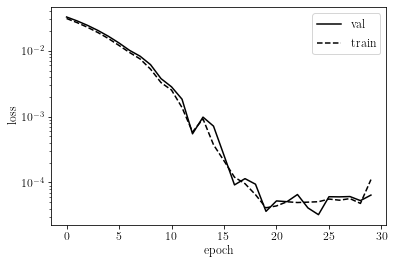

<Figure size 432x288 with 0 Axes>

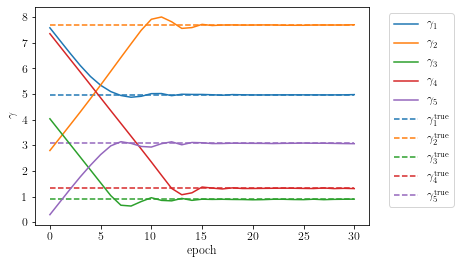

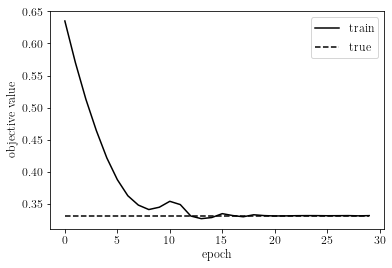

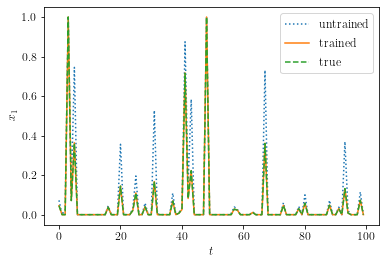

In [38]:
plot_results(val_losses_nd, train_losses_nd, param_updates_nd, obj_vals_nd, gamma_true, Sx0val, X_untrained_nd, X_trained_nd, Xval_nd[:,:,1:], 'nd')

In [66]:
# results
print('final gamma estimate: ', param_updates_nd[-1,:].detach().numpy()[0])
print('true gamma: ', gamma_true.detach().numpy())
print('final objval estimate: ', obj_vals_nd[-1])
print('true objval: ', f_plot(Sx0val[0,:,:],Xval_nd[0,:,1:],0).detach().numpy())

final gamma estimate:  4.973354
true gamma:  [4.962566  7.682218  0.8847743 1.3203049 3.0742283]
final objval estimate:  0.3320762515068054
true objval:  0.33197832


# method 2: distributed

In [25]:
QUIET    = 1
MAX_ITER = 15
rho = 1

In [26]:
def constr_dist(x,i,gamma):
    x_i = x[i]
    constraints = [cp.sum(x_i) == gamma[i],
                   x_i >= 0,
                   x_i <= 1]
    return constraints

def f(x,S,pz,i):
    quad = cp.sum_squares(cp.multiply(S,x[i]))
    lin = pz.T@x[i]
    return quad + lin

def g(zbar,S_x0,px0):
    lin = px0.T@(m*zbar)
    return S_x0 + lin

In [27]:
# set up x-update step
x = [cp.Variable(h)]*m
v = cp.Parameter(h)
gamma = cp.Parameter(m)
S = cp.Parameter(h)
pz = cp.Parameter(h)

obj_x = [f(x,S,pz,i) + (rho/2)*cp.sum_squares(x[i]-v) for i in range(m)]
prox_x = [cp.Problem(cp.Minimize(obj_x[i]), constr_dist(x,i,gamma)) for i in range(m)]
layers_x = [CvxpyLayer(prox_x[i],[v,gamma,S,pz],[x[i]]) for i in range(m)]

In [28]:
# set up z-update step
zbar = cp.Variable(h)
S_x0 = cp.Parameter()
abar = cp.Parameter(h)
px0 = cp.Parameter(h)

obj_z = g(zbar,S_x0,px0) + (m*rho/2)*cp.sum_squares(zbar-abar)
prox_z = cp.Problem(cp.Minimize(obj_z))
layer_z = CvxpyLayer(prox_z,[abar,S_x0,px0],[zbar])

In [29]:
def admm(Sx0,gamma,layers_x,layer_z):
    N = Sx0.shape[0]
    S,x0 = Sx0[:,:,0],Sx0[:,:,1]
    p = torch.square(S)
    
    X = torch.zeros((N,h,m))
    Z = torch.zeros((N,h,m))
    Zbar = torch.zeros((N,h))
    U = torch.zeros((N,h))
    r_norm = torch.zeros((N,MAX_ITER))
    s_norm = torch.zeros((N,MAX_ITER))
    
    for k in tqdm(range(MAX_ITER)):
        # x-update
        for i in range(m):
            v = X[:,:,i] - torch.mean(X,axis=2) + Zbar - U
            pz = p*(torch.sum(Z[:,:,np.arange(m)!=i],axis=2) + x0)
            X[:,:,i] = layers_x[i](v,gamma,S,pz,solver_args={"solve_method":'ECOS'})[0]
            
        Xbar = torch.mean(X,axis=2)
            
        # z-update
        abar = U + Xbar
        S_x0 = torch.square(torch.norm(S*x0,dim=1))
        px0 = p*x0
        Zbar = layer_z(abar,S_x0,px0,solver_args={"solve_method":'ECOS'})[0]
        Z_old = Z
        Z = Zbar.repeat(m,1,1).permute(1,2,0) + X - Xbar.repeat(m,1,1).permute(1,2,0)

        
        # u-update
        U  += Xbar - Zbar
        
        # progress tracking
        r_norm[:,k] = torch.flatten(torch.linalg.norm(Xbar-Zbar,dim=1))
        s_norm[:,k] = torch.flatten(torch.linalg.norm(rho*(torch.reshape(Z_old,(N,h*m))-torch.reshape(Z,(N,h*m))),dim=1))
        

    return X,r_norm,s_norm

## forward pass

In [30]:
def get_data_d(N, Sx0, gamma):
    gamma = gamma.repeat(N,1)
    X,r_norm,s_norm = admm(Sx0,gamma,layers_x,layer_z)
    return X,r_norm,s_norm

X_d,r_norm,s_norm = get_data_d(100, Sx0, gamma_true)
Xval_d,r_normval,s_normval = get_data_d(50, Sx0val, gamma_true)

100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


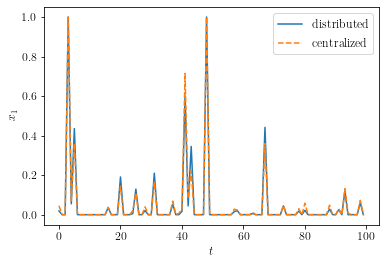

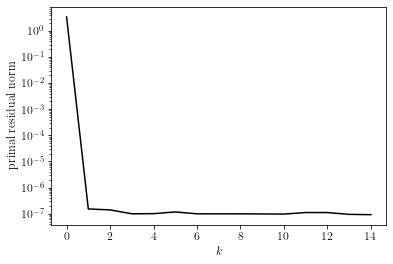

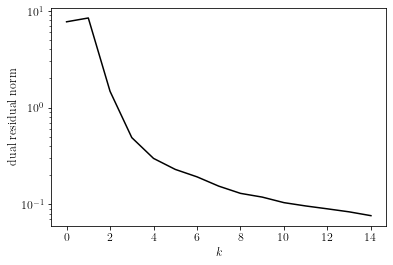

In [57]:
# compare results
plt.figure(figsize=(6,4))
plt.plot(Xval_d[0,:,0], label = 'distributed')
plt.plot(Xval_nd[0,:,1], '--', label = 'centralized')
plt.legend()
# plt.title('Comparison of $x_1$ values calculated using ADMM and centralized methods')
plt.xlabel('$t$')
plt.ylabel('$x_1$')
plt.savefig('figures/pev2/fp_comp.pdf')

# primal residual tracking
plt.figure(figsize=(6,4))
plt.plot(r_normval[0,:], 'k')
plt.yscale('log')
# plt.title('Primal residual norms by iteration')
plt.xlabel('$k$')
plt.ylabel('primal residual norm')
plt.savefig('figures/pev2/fp_rnorm.pdf')

# dual residual tracking
plt.figure(figsize=(6,4))
plt.plot(s_normval[0,:], 'k')
plt.yscale('log')
# plt.title('Dual residual norms by iteration')
plt.xlabel('$k$')
plt.ylabel('dual residual norm')
plt.savefig('figures/pev2/fp_snorm.pdf')

# backward pass

In [32]:
l1_loss = torch.nn.L1Loss()
torch.manual_seed(1)
gamma = torch.rand(m)*10
print(gamma)
gamma.requires_grad_(True)

def loss_d(Sx0,x,gamma):
    N = Sx0.shape[0]
    gamma = gamma.repeat(N,1)
    return l1_loss(admm(Sx0,gamma,layers_x,layer_z)[0],x)

tensor([7.5763, 2.7931, 4.0307, 7.3468, 0.2928])


In [33]:
val_losses_d, train_losses_d, param_updates_d = fit(lambda Sx0,X: loss_d(Sx0,X,gamma), [gamma], Sx0, X_d, Sx0val, Xval_d,
                                                    opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                                                    batch_size=20, epochs=epochs, verbose=True)

  0%|          | 0/15 [00:00<?, ?it/s]

001 | 0.03891


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.03891


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.03841


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.03791


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.03741


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.03691


  0%|          | 0/15 [00:00<?, ?it/s]

002 | 0.03391


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.03391


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.03341


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.03291


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.03241


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.03191


  0%|          | 0/15 [00:00<?, ?it/s]

003 | 0.02891


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.02891


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.02841


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.02791


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.02741


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.02691


  0%|          | 0/15 [00:00<?, ?it/s]

004 | 0.02391


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.02391


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.02341


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.02291


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.02241


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.02191


  0%|          | 0/15 [00:00<?, ?it/s]

005 | 0.01892


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01891


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01842


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01793


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01745


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01696


  0%|          | 0/15 [00:00<?, ?it/s]

006 | 0.01424


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01421


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01386


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01351


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01320


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01290


  0%|          | 0/15 [00:00<?, ?it/s]

007 | 0.01111


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01115


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01085


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01066


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01052


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01039


  0%|          | 0/15 [00:00<?, ?it/s]

008 | 0.00953


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00949


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00932


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00911


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00890


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00865


  0%|          | 0/15 [00:00<?, ?it/s]

009 | 0.00714


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00717


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00684


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00659


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00633


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00607


  0%|          | 0/15 [00:00<?, ?it/s]

010 | 0.00463


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00461


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00438


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00414


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00395


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00380


  0%|          | 0/15 [00:00<?, ?it/s]

011 | 0.00303


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00299


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00293


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00285


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00277


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00266


  0%|          | 0/15 [00:00<?, ?it/s]

012 | 0.00196


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00194


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00179


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00167


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00156


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00143


  0%|          | 0/15 [00:00<?, ?it/s]

013 | 0.00079


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00079


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00083


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00085


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00083


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00081


  0%|          | 0/15 [00:00<?, ?it/s]

014 | 0.00090


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00090


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00096


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00100


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00101


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00100
new lr: 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

015 | 0.00083


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00082


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00074


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00064


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00052


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00045


  0%|          | 0/15 [00:00<?, ?it/s]

016 | 0.00026


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00026


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00027


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00026


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00024


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00022


  0%|          | 0/15 [00:00<?, ?it/s]

017 | 0.00017


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00017


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00017


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

018 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00010


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

019 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

020 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

021 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

022 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

023 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

024 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

025 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

026 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

027 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

028 | 0.00002


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00002


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

029 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00003


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00003
new lr: 0.025


  0%|          | 0/15 [00:00<?, ?it/s]

030 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00013


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00015


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00013


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


batch 005 / 005 | 0.00012


In [34]:
N = Sx0val.shape[0]
obj_vals_d = np.zeros(epochs)
for epoch in range(epochs):
    gamma_temp = param_updates_d[epoch,:]
    X_temp = layer(Sx0val,gamma_temp,solver_args={"solve_method":'ECOS'})[0][0,:,1:]
    obj_vals_d[epoch] = f_plot(Sx0val[0,:,:],X_temp,0)

X_untrained_d = admm(Sx0val,param_updates_d[0,:].repeat(N,1),layers_x,layer_z)[0][0,:,:]
X_trained_d = admm(Sx0val,param_updates_d[-1,:],layers_x,layer_z)[0][0,:,:]

100%|██████████| 15/15 [00:42<00:00,  2.84s/it]


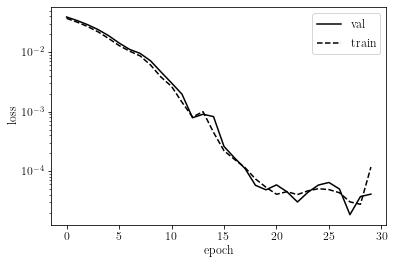

<Figure size 432x288 with 0 Axes>

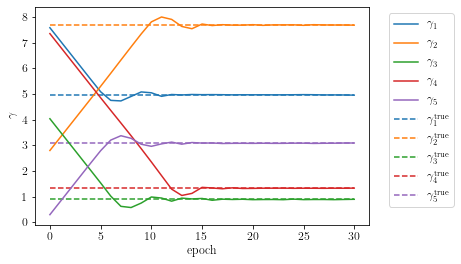

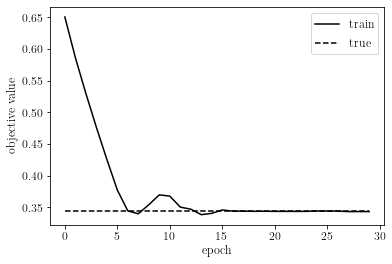

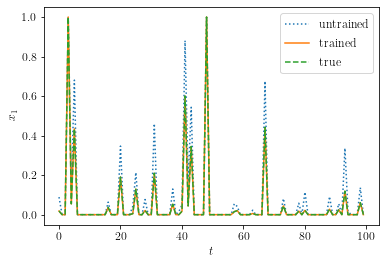

In [39]:
plot_results(val_losses_d, train_losses_d, param_updates_d, obj_vals_d, gamma_true, Sx0val, X_untrained_d, X_trained_d, Xval_d, 'd')

In [69]:
# results
print('final gamma estimate: ', param_updates_d[-1,:].detach().numpy()[0])
print('true gamma: ', gamma_true.detach().numpy())
print('final objval estimate: ', obj_vals_d[-1])
print('true objval: ', f_plot(Sx0val[0,:,:],Xval_nd[0,:,1:],0).detach().numpy())

final gamma estimate:  4.949817
true gamma:  [4.962566  7.682218  0.8847743 1.3203049 3.0742283]
final objval estimate:  0.33159077167510986
true objval:  0.33197832
